In [55]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import open3d as o3d
import os
import point_cloud_utils as pcu
import pymap3d as pm
import re
import seaborn as sns
import map_metrics

from copy import deepcopy
# from evo.tools.plot import *
from evo.core.lie_algebra import se3_inverse
from evo.tools.settings import SETTINGS
from evo.tools.file_interface import read_tum_trajectory_file
from os import path
from scipy.spatial.transform import Rotation as R
from tools.internal.plot_settings import get_figsize

from pyproj import Proj, transform
%matplotlib widget

SETTINGS.plot_split = True
SETTINGS.plot_usetex = True

result_figure_dir = "/mnt/c/Users/J-Dau/OneDrive/TUM/04_SS23/02_MA/02_Figures/08_ch-6-results/07_global_consistency/"

## PCLs

### Submaps

In [3]:
indices = [412 ,413 ,415 ,417 ,420 ,422 ,424 ,427 ,429 ,430 ,431 ,432 ,433 ,434 ,435 ,436 ,437 ,438 ,439 ,441]

files = []

for entry in os.listdir("/home/julian/projects/thesis/datasets/converted/mdv3_1/mdv3_full_merge/pcd_processed/"):
    if entry.endswith(".pcd"):
        files.append(entry)
        
files.sort()

rfiles = [f for i, f in enumerate(files) if i in indices]

print("\n".join(rfiles))

1689869734_516791978_0.pcd
1689869734_623684800_0.pcd
1689869734_815829808_0.pcd
1689869735_016041287_0.pcd
1689869735_321909948_0.pcd
1689869735_518639457_0.pcd
1689869735_721297577_0.pcd
1689869736_125109268_0.pcd
1689869736_687370235_0.pcd
1689869737_073804720_0.pcd
1689869737_228942027_0.pcd
1689869737_873702209_0.pcd
1689869738_010345310_0.pcd
1689869738_210489309_0.pcd
1689869738_303521387_0.pcd
1689869738_418083771_0.pcd
1689869738_817768350_0.pcd
1689869738_917118090_0.pcd
1689869739_023334831_0.pcd
1689869739_223792231_0.pcd


In [3]:
cds = [] 
hds = []
for i in range(0, 58):

    path1 = f"/home/julian/projects/thesis/datasets/mapping_analysis/mdv3_1/transformed/submap_{i:03d}-075-optimized_orig_frame.ply"
    path2 = f"/home/julian/projects/thesis/datasets/mapping_analysis/mdv3_1/transformed/submap_{i:03d}-075-original_orig_frame.ply"

    # p1 is an (n, 3)-shaped numpy array containing one point per row
    p1 = pcu.load_mesh_v(path1)

    # p2 is an (m, 3)-shaped numpy array containing one point per row
    p2 = pcu.load_mesh_v(path2)

    # Compute the chamfer distance between p1 and p2
    cd = pcu.chamfer_distance(p1, p2)
    
    hd = pcu.hausdorff_distance(p1, p2)
    
    cds.append((cd, i))
    hds.append((hd, i))
    
    # emd, pi = pcu.earth_movers_distance(p1, p2)
    
        
    # if emd > max_emd[0]:
    #     max_emd = (emd, i)
        

In [3]:
cds_sorted = sorted(cds, key=lambda x: x[0], reverse=True)
hds_sorted = sorted(hds, key=lambda x: x[0], reverse=True)

<Figure size 640x480 with 0 Axes>

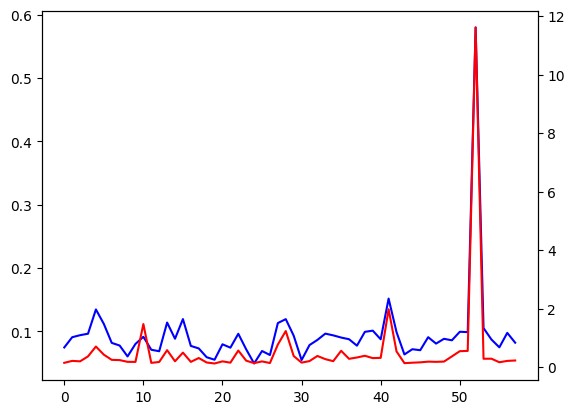

In [14]:
plt.figure()

cd = np.asarray(cds)
hd = np.asarray(hds)

fig, ax = plt.subplots()

ax2 = ax.twinx()

ax.plot(cd[:,1], cd[:,0], color="b")
ax2.plot(hd[:,1], hd[:,0], color="r")

In [10]:
string = "HD: {:.3f} Key = {:02d} \t CD: {:.3f} Key = {:02d}"

res= "\n".join([string.format(hd[0], hd[1], cd[0], cd[1]) for (hd,cd) in zip(hds_sorted, cds_sorted)])
print(res)

HD: 0.122 Key = 19 	 CD: 0.049 Key = 24
HD: 0.133 Key = 43 	 CD: 0.055 Key = 30
HD: 0.135 Key = 24 	 CD: 0.055 Key = 19
HD: 0.137 Key = 26 	 CD: 0.059 Key = 18
HD: 0.143 Key = 11 	 CD: 0.060 Key = 08
HD: 0.144 Key = 00 	 CD: 0.063 Key = 26
HD: 0.149 Key = 44 	 CD: 0.064 Key = 43
HD: 0.150 Key = 21 	 CD: 0.069 Key = 12
HD: 0.151 Key = 30 	 CD: 0.069 Key = 25
HD: 0.156 Key = 18 	 CD: 0.070 Key = 45
HD: 0.161 Key = 45 	 CD: 0.071 Key = 11
HD: 0.164 Key = 55 	 CD: 0.072 Key = 23
HD: 0.174 Key = 12 	 CD: 0.072 Key = 44
HD: 0.176 Key = 09 	 CD: 0.073 Key = 17
HD: 0.177 Key = 16 	 CD: 0.074 Key = 21
HD: 0.178 Key = 47 	 CD: 0.075 Key = 00
HD: 0.178 Key = 08 	 CD: 0.075 Key = 55
HD: 0.185 Key = 46 	 CD: 0.077 Key = 16
HD: 0.187 Key = 48 	 CD: 0.077 Key = 37
HD: 0.193 Key = 25 	 CD: 0.078 Key = 07
HD: 0.195 Key = 20 	 CD: 0.078 Key = 31
HD: 0.195 Key = 02 	 CD: 0.080 Key = 20
HD: 0.198 Key = 14 	 CD: 0.080 Key = 09
HD: 0.201 Key = 34 	 CD: 0.081 Key = 47
HD: 0.204 Key = 31 	 CD: 0.082 Key = 06


### Global Map

In [ ]:

p_optimized     = "/home/julian/projects/thesis/datasets/mapping_analysis/submaps_075_optimized/optimized.ply"
p_optimized_loo = "/home/julian/projects/thesis/datasets/mapping_analysis/submaps_075_optimized/optimized_loop_closure.ply"
p_original      = "/home/julian/projects/thesis/datasets/mapping_analysis/submaps_075_original/original.ply"



# p1 is an (n, 3)-shaped numpy array containing one point per row
opt      = pcu.load_mesh_v(p_optimized)
opt_loop = pcu.load_mesh_v(p_optimized_loo)
orig     = pcu.load_mesh_v(p_original)


# Compute the chamfer distance between p1 and p2
print(pcu.chamfer_distance(opt, opt_loop))
print(pcu.chamfer_distance(opt, orig))
print(pcu.chamfer_distance(opt_loop, orig))


In [14]:
p_ref           = "/home/julian/projects/thesis/datasets/mapping_analysis/reference.ply"
p_ali           = "/home/julian/projects/thesis/datasets/mapping_analysis/opt_075_aligned.ply"
ref      = pcu.load_mesh_v(p_ref)
ali      = pcu.load_mesh_v(p_ali)

print(f"Chamfer Distance: {pcu.chamfer_distance(ref, ali)}")
print(f"Hausdorff Distance: {pcu.hausdorff_distance(ref, ali)}")




Chamfer Distance: 1.2915695905685425
Hausdorff Distance: 143.11033630371094


### Global Referenciation

In [2]:
gps_path = "/home/julian/projects/thesis/datasets/gps_data/mdv3_1/oxts/data/0000000000.txt"
with open(gps_path, 'r') as f:
    content = f.readline().split(' ')
    x_1 = (float(content[0]), float(content[1]), float(content[2]))
    
gps_path = "/home/julian/projects/thesis/datasets/gps_data/mdv3_1/oxts/data/0000022222.txt"
with open(gps_path, 'r') as f:
    content = f.readline().split(' ')
    x_2 = (float(content[0]), float(content[1]), float(content[2]))
    
print(pm.geodetic2enu(*x_1, *x_1))
print(pm.geodetic2enu(*x_2, *x_1))

(0.0, 0.0, 0.0)
(294.6900214095163, 233.0174741641589, -0.5086814650652514)


In [42]:
# pcd_path = "/home/julian/projects/thesis/datasets/mapping_analysis/submaps_075_optimized/optimized.pcd"
pcd_path = "/home/julian/projects/thesis/datasets/mapping_analysis/route_1-test-origin.pcd"
pcd_origin_path = "/home/julian/projects/thesis/datasets/mapping_analysis/submaps_075_optimized/submaps/submap_000.odom"

# pcd_path = "/home/julian/projects/thesis/datasets/mapping_analysis/reference.pcd"


gps_path = "/home/julian/projects/thesis/datasets/gps_data/mdv3_1/oxts/data/0000000000.txt"


submap_1_origin = read_tum_trajectory_file(pcd_origin_path)

# Starting position in WGS84 -> Origin of ENU Frame
with open(gps_path, 'r') as f:
    content = f.readline().split(' ')
    p_0_wgs = (float(content[0]), float(content[1]), float(content[2]))


# x_0_rot = R.from_matrix([[ 0.97147693,  0.23670935,  0.01418685],
#                          [-0.23646208,  0.9714895 , -0.0171419 ],
#                          [-0.01784002,  0.01329831,  0.99975241]])

x_0_rot = R.from_euler('xyz',[0.76208075,   1.02221219, -11.68004258] ,degrees=True)

x_0 = np.identity(4)
x_0[:3, :3] = x_0_rot.as_matrix()

p_UTM = (48.27222560629247, 11.66849291944447, p_0_wgs[2])

t_utm = np.eye(4)
t_utm[:3, 3] = np.asarray(pm.geodetic2enu(*p_UTM, *p_0_wgs))


In [43]:
# PCD in origin for submap 1
pcd = o3d.io.read_point_cloud(pcd_path)
pcd_down_o = pcd.voxel_down_sample(0.2)


In [53]:
pcd_down = deepcopy(pcd_down_o)
lat, lon, _ = p_0_wgs

# Convert WGS84 to UTM
proj_utm = Proj(proj='utm', zone=32, ellps='WGS84')
x_utm, y_utm = proj_utm(lon, lat)
print(f"UTM Coordinates of PCL Origin: ({x_utm}, {y_utm})")

# Assuming you have the UTM coordinates of the satellite image origin
image_origin_x, image_origin_y = 698000, 5350000

# Translate the PCL to align with the satellite image
pcl_translation_x = image_origin_x - x_utm
pcl_translation_y = image_origin_y - y_utm

print(f"x-translation: {pcl_translation_x}")
print(f"y-translation: {pcl_translation_y}")


origin_transform = np.eye(4)
origin_transform[0:3, 3] = (pcl_translation_x, pcl_translation_y, 0)

x_0_yaw = R.from_euler("xyz", [0,0,-8], degrees=True)
t_align = np.identity(4)
t_align[:3,:3] = x_0_yaw.as_matrix()

pcd_down.transform(t_align)
pcd_down.transform(se3_inverse(origin_transform))
o3d.io.write_point_cloud("/home/julian/projects/thesis/datasets/mapping_analysis/route_1-test-origin-aligned.pcd", pcd_down)

UTM Coordinates of PCL Origin: (698064.850476714, 5349129.459771032)
x-translation: -64.85047671396751
y-translation: 870.5402289675549


True

In [22]:
pcd_down = deepcopy(pcd_down_aligned)


# PCD is aligned with x_0 
# pcd_down.transform(submap_1_origin.poses_se3[0])
# pcd_down.transform(se3_inverse(submap_1_origin.poses_se3[0]))

# PCD is aligned with origin w.r.t True North
# t_align = np.identity(4)
# t_align[:3,:3] = R.from_euler("xyz", [0,0,-9], degrees=True).as_matrix()
# pcd_down.transform(t_align)
# pcd_down.transform(x_0)

# PCD is aligned with starting point in the image
# pcd_down.transform(se3_inverse(t))
# pcd_down.transform(t)

# transform = x_0 @ se3_inverse(t_utm)

# pcd_down.transform(x_0)
pcd_down.transform(se3_inverse(t_utm))
# pcd_down.transform(transform)
# pcd_down_aligned.transform(t_align)
# pcd_down.transform(se3_inverse(submap_1_origin.poses_se3[0]))


o3d.io.write_point_cloud("/home/julian/projects/thesis/datasets/mapping_analysis/route_1-test-origin-aligned.pcd", pcd_down)

True

### Metrics

In [ ]:
pcd_root = "/home/julian/projects/thesis/datasets/ext/kitti/sequences/"

seq = "02"
optim = False

pcd_path = path.join(pcd_root, seq, f"kitti_{seq}{'_' if optim else '_no_'}optim.pcd")
pcl = o3d.io.read_point_cloud(pcd_path)

## Graph

### Read Graph

In [2]:
# dot_file = "/home/julian/projects/thesis/datasets/mapping_analysis/submaps_075_optimized/graph.dot"
dot_file = "/home/julian/projects/thesis/datasets/mapping_analysis/FactorGraph.dot"

POS_REGEX = re.compile(r"pos\s?=\s?\"(\d+.?\d*,\d+.?\d*)!\"")
LABEL_REGEX = re.compile(r"label\s?=\s?\"(\d+)\"")
# FACTOR_REGEX = re.compile(r"facotr(\d+)")


FACTOR_REGEX = re.compile(r"var(\d+)\s--\sfactor(\d+)")

with open(dot_file, 'r') as f:
    dot_content = f.readlines()

variables = {}
factors = {}
unary_factors = {}
binary_factors = {}

factor_mode = False
current_factor = ""

for line in dot_content:
    line = line.strip()
    # if factor_mode:
    #     # Parsing factors
    #     pass
    # else:
    #     # Parsing variables
        
    if LABEL_REGEX.search(line):
        label = int(LABEL_REGEX.search(line).group(1))
        pos = POS_REGEX.search(line).group(1)
        x,y = pos.split(",")
        if variables.get(label) is not None:
            print(f"Warning: Label {label} already exists")
        else:
            variables[label] = (float(x),float(y))
            
    factor_reg = FACTOR_REGEX.search(line)
    if factor_reg:
        var = factor_reg.group(1)
        factor = factor_reg.group(2)
        if factors.get(factor) is not None:
            factors[factor].append(var)
        else:
            factors[factor] = [var]
        
        # if line.startswith('factor'):
        #     # New factor started
        #     # TODO: Finish the last one
            
        #     factor_mode = True
        #     current_factor = int(FACTOR_REGEX.search(line))
        #     if factors.get(current_factor) is not None:
        #         print(f"Warning: Factor {current_factor} already exists!")
        #     else:
        #         factors[current_factor] = []
            
for f, vars in factors.items():
    if len(vars) == 1:
        unary_factors[f] = vars[0]
    else:
        binary_factors[f] = vars

# Output the results
print("Variables:", variables)
print("Factors:", factors)
print("Unary Factors:", unary_factors)
print("Binary Factors:", binary_factors)

# print("Other Factors:", other_factors)

Variables: {0: (21.9323, 9.027), 1: (13.4931, 57.5449), 2: (6.67529, 95.8563), 3: (0.0, 126.158), 4: (0.0805872, 141.67), 5: (29.2577, 149.986), 6: (63.9309, 156.413), 7: (91.3306, 161.347), 8: (122.57, 167.358), 9: (153.152, 173.244), 10: (196.049, 180.956), 11: (235.175, 188.785), 12: (274.442, 195.992), 13: (283.578, 213.349), 14: (277.783, 244.739), 15: (272.852, 267.147), 16: (263.924, 279.058), 17: (249.381, 283.599), 18: (232.151, 281.152), 19: (207.294, 277.694), 20: (181.179, 272.263), 21: (158.162, 267.877), 22: (135.334, 263.226), 23: (113.437, 258.873), 24: (96.4288, 255.176), 25: (76.5462, 251.234), 26: (58.7316, 247.676), 27: (38.4998, 243.302), 28: (24.6583, 260.619), 29: (41.5824, 269.725), 30: (71.3438, 275.928), 31: (90.2202, 279.999), 32: (119.643, 285.72), 33: (146.94, 277.358), 34: (170.241, 281.194), 35: (216.993, 290.75), 36: (246.827, 292.936), 37: (264.958, 283.408), 38: (278.383, 258.581), 39: (285.015, 224.664), 40: (289.138, 204.942), 41: (284.215, 196.014),

### Read Errors

In [5]:
# error_path = "/home/julian/projects/thesis/datasets/mapping_analysis/factor_values_full_merge.data"
error_path = "/home/julian/projects/thesis/datasets//factor_values.data"
error_data = []

ERROR_REGEX = re.compile(r"(\d+) -- (\d+)-(\d+) -- (\d+.?\d*)")

with open(error_path, 'r') as f:
    error_data = f.readlines()
    
edge_errors_it = {}
for line in error_data:
    match = ERROR_REGEX.search(line)
    if match: 
        iteration =int(match.group(1))
        src_node =    int(match.group(2))
        target_node = int(match.group(3))
        error = float(match.group(4))
        
    entry = ((src_node, target_node), error)
    if edge_errors_it.get(iteration) is None:
        edge_errors_it[iteration] = {}
    edge_errors_it[iteration][entry[0]] = entry[1]
    

### Create Diagram

In [3]:
nodes = [(k, {'pos': (x,y)}) for k,(x,y) in variables.items()]
edges = [(int(src), int(target)) for (src, target) in list(binary_factors.values())]

# print(len(nodes))
# print(len(edges))

G = nx.Graph()

for var, pos in variables.items():
    G.add_node(var, pos=pos[::-1])
# G.add_edges_from(edges)

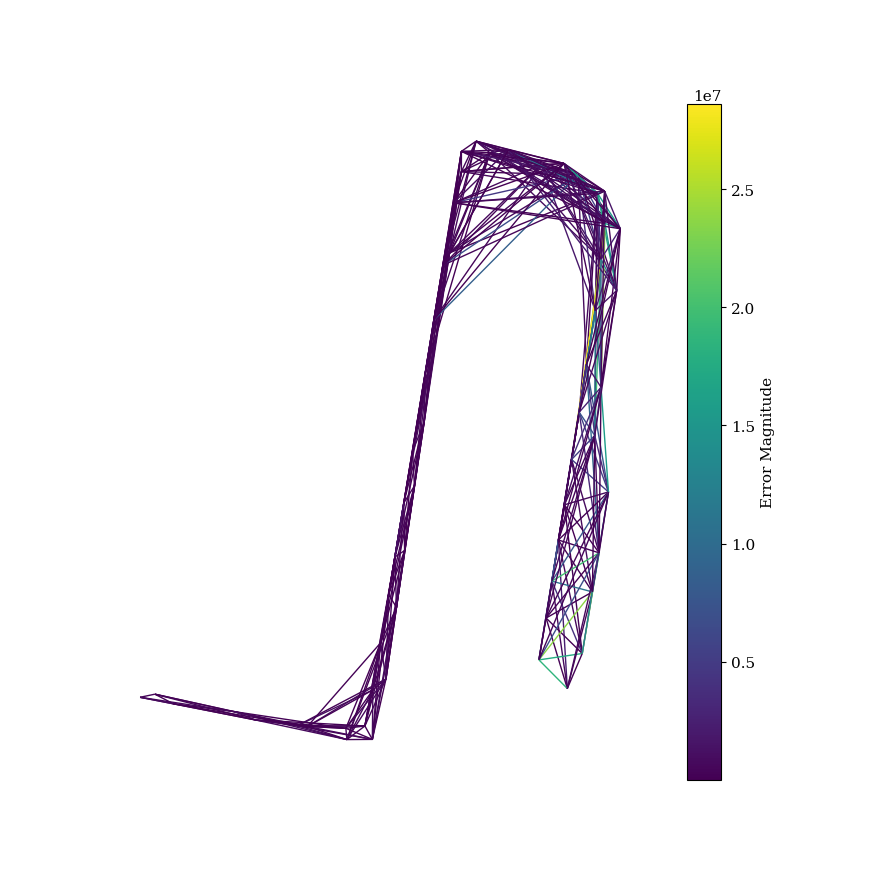

In [6]:
edge_errors = edge_errors_it[0]

cmap = plt.cm.viridis

# Normalize the error values for coloring
errors = np.array(list(edge_errors.values()))
norm = plt.Normalize(errors.min(), errors.max())
colors = cmap(norm(errors))

G.add_edges_from(edge_errors.keys())  # Add edges

# Extract positions
pos = nx.get_node_attributes(G, 'pos')

# Plot the graph
plt.figure(figsize=get_figsize(wf=1.5, hf=1))
for (u, v), color in zip(G.edges(), colors):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=[color], width=1)

# nx.draw_networkx_nodes(G, pos, node_color='', node_size=15)
# Optional: Add labels, title, etc.
# plt.title('Graph Visualization with Edge Colors Based on Errors')

# Creating a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label='Error Magnitude')



ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.savefig(path.join(result_figure_dir, "graph-with-error.pdf"), format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
# Extract the positions from the node data
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
plt.figure(figsize=get_figsize(wf=1, hf=1))  # Set the size of the figure (optional)
nx.draw(G, pos, with_labels=False, node_color='black', edge_color='#0065BD', node_size=15)
# plt.title('Graph Visualization')

# plt.tight_layout()

matplotlib.rcParams.update({'font.size': 16})

# plt.savefig(path.join(result_figure_dir, "graph.pdf"), format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Draw the nodes with a subtle border
node_size = 50
node_color = "black"
edge_color ="#0065BD"
edge_width = 1
edge_alpha = 1
font_color = "white"
font_size = 8
font_weight = 2

plt.figure(figsize=get_figsize(wf=2, hf=1))  # Set the size of the figure (optional)

nx.draw_networkx_nodes(G, pos, node_size=node_size, alpha=1,
                       node_color=node_color, edgecolors=edge_color)

# Draw the edges with a lighter color
nx.draw_networkx_edges(G, pos, width=edge_width, alpha=edge_alpha,
                       edge_color=edge_color)

# Draw the labels with a softer color
nx.draw_networkx_labels(G, pos, font_size=font_size, font_color=font_color,
                        font_weight=font_weight)

# Remove the axes
plt.axis('off')

### Heatmap Plot

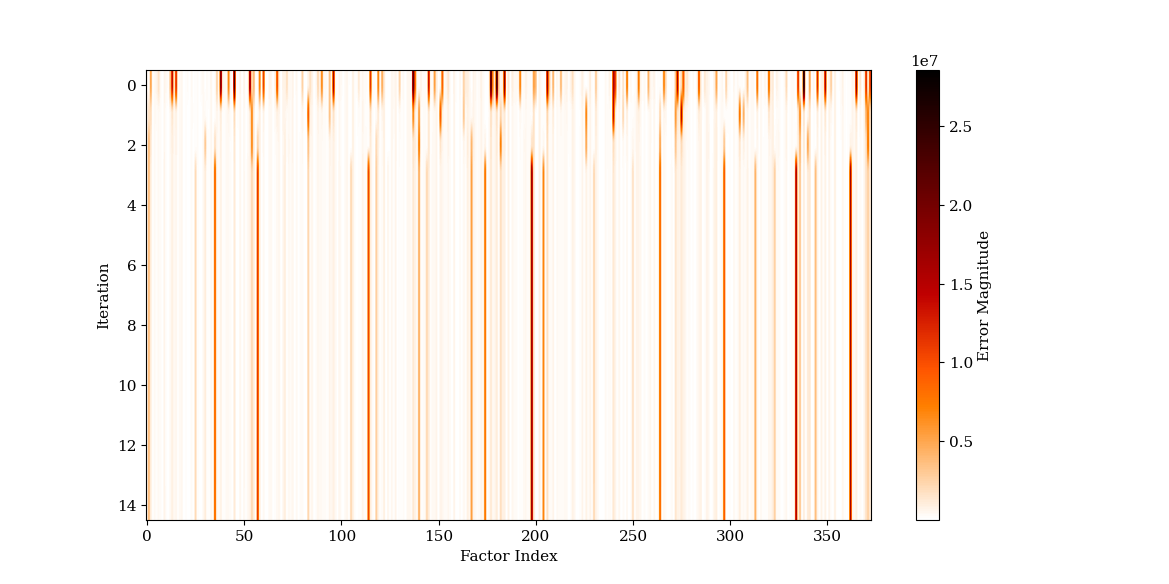

In [7]:

plt.close('all')
# Step 1: Identify unique edges
unique_edges = set(edge for iteration in edge_errors_it.values() for edge in iteration)

# Create a mapping from edge to index
edge_to_index = {edge: i for i, edge in enumerate(unique_edges)}

# Step 2: Create a 2D array for the heatmap
num_iterations = len(edge_errors_it)
num_edges = len(unique_edges)
heatmap_data = np.zeros((num_iterations, num_edges))

# Step 3: Fill the 2D array with error values
for iteration, edges in edge_errors_it.items():
    for edge, error in edges.items():
        heatmap_data[iteration, edge_to_index[edge]] = error


plt.figure(figsize=get_figsize(wf=2, hf=.5))
plt.imshow(heatmap_data, cmap=plt.cm.gist_heat_r, aspect='auto')
plt.colorbar(label='Error Magnitude')
plt.xlabel('Factor Index')
plt.ylabel('Iteration')
# plt.title('Heatmap of Error Values Over Iterations and Edges')

plt.savefig(path.join(result_figure_dir, "graph-heatmap.pdf"), format="pdf", bbox_inches="tight")
plt.show()



In [49]:
edge_errors_it.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

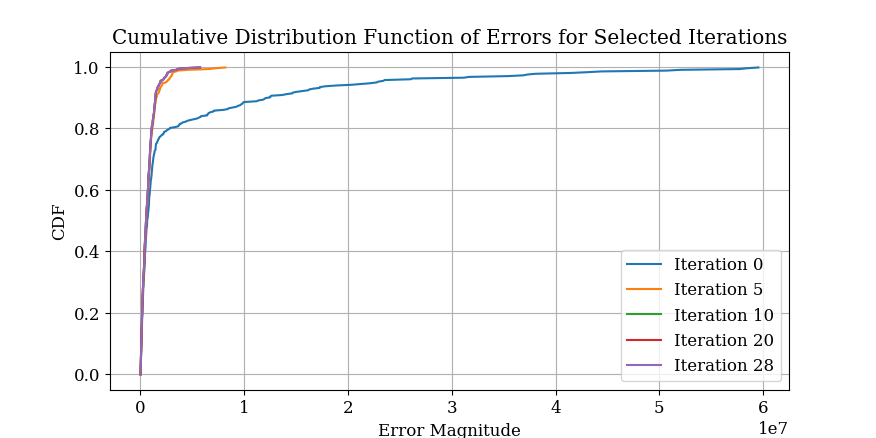

In [67]:
plt.close('all')
# matplotlib.rcParams.update({'font.size': 12})

# Selected iterations for subplots: 0th, 10th, and last
selected_iterations = [0, 5, 10, 20, 28]

# Create CDF plots for each selected iteration
plt.figure(figsize=get_figsize(1.5,0.5))

for iteration in selected_iterations:
    # Extract errors for the specific iteration
    iteration_errors = heatmap_data[iteration, :]

    # Sort the error values
    sorted_errors = np.sort(iteration_errors)

    # Calculate the cumulative distribution
    cdf = np.arange(len(sorted_errors)) / float(len(sorted_errors))

    # Plotting the CDF
    plt.plot(sorted_errors, cdf, label=f'Iteration {iteration}')

plt.xlabel('Error Magnitude')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Errors for Selected Iterations')
plt.legend()
plt.grid(True)
plt.show()